In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class Tree: 
    
    def __init__(self, X, y, max_depth, min_leaf_size=5): 
        self.X = X
        self.y = y 
        self.max_depth = max_depth
        self.depth = 0
        self.min_leaf_size = min_leaf_size
        
    def add_branch(self, ret=False):
        X = self.X
        y = self.y 
        store = []
        for c in X.columns: 
            store.append(self.best_split(X, y, c))
        store = pd.DataFrame(store, columns= ['var', 'ss', 'split', 'rule'])
        [var, ss, split, rule] = store.sort_values('ss').iloc[0]
        self.branch_l = Branch(X[X[var]<=split], y[X[var]<=split],
                                 var, split, direction='left', 
                                      max_depth=self.max_depth-1)
        self.branch_r = Branch(X[X[var]>split], y[X[var]>split],
                                 var, split, direction='right', 
                                   max_depth=self.max_depth-1)
        if ret: 
            return [self.branch_l, self.branch_r]
        
    def best_split(self, X, y, var): 
        x = X[var]
        y = y[x.sort_values().index]
        ss = []
        
        nl, sl = 0, 0 
        nr = y.shape[0]
        sr = y.sum()
        sst = np.sum(y**2)
        
        ss_0 = sst - sr**2/nr
        ss.append(ss_0)
        
        for yi in y[:-1]: 
            nl +=1
            sl += yi
            nr -=1 
            sr -= yi
            
            ss_i =sst - sl**2/nl - sr**2/nr
            ss.append(ss_i)
        sl += y.iloc[-1]
        ss_len = sst- sl**2/len(y)
        
        min_ss = np.min(ss)
    
        split = x.sort_values().iloc[np.argmin(ss)]
        return [var, min_ss, split, var + "<=" + str(split)]
    
    def build_tree(self, level=None, return_=False): 
        if level is None: 
            level = self.max_depth
        if level==0: 
            trees = [t.add_branch(ret=True) for t in [self]]
            trees = [t[i] for t in trees for i in [0,1]]
        else: 
            trees = [t.add_branch(ret=True) for t in self.build_tree(level-1) if len(t.y)>1]
            trees = [t[i] for t in trees for i in [0,1]]
        return trees
    
    def leaf(self, x, base=None, lvl=1): 
        if base is None: 
            base = self

        var, split = base.branch_l.split_var, base.branch_l.split
        if x[var]<= split:
            branch = base.branch_l
        else: 
            branch = base.branch_r
        if lvl <self.max_depth: 
            return self.leaf(x=x, base=branch, lvl=lvl+1)
        else: 
            return branch
        
    def predict(self, Xnew):
        pred = [self.leaf(x).mean for i, x in Xnew.iterrows()]
        return pd.Series(pred)

class Branch(Tree): 
    def __init__(self, X, y, split_var, split, direction, max_depth): 
        Tree.__init__(self, X, y, max_depth)
        self.split_var = split_var
        self.split = split
        self.direction = direction
        self.mean = y.mean()

In [3]:
# apply to Ames housing price data (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
df = pd.read_csv('/Users/carlgreen/Documents/Data/Ames/train.csv')

In [4]:
df.select_dtypes(include=np.number).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [5]:
#choose three features
features = ['LotArea', 'GrLivArea', 'YearBuilt']
df[features].isnull().sum()

LotArea      0
GrLivArea    0
YearBuilt    0
dtype: int64

In [6]:
#target variable
target = 'SalePrice_log'
df[target] = np.log(df['SalePrice'])

In [19]:
#initialize tree object
tree = Tree(X=df[features], y=df[target], max_depth=3)

In [20]:
# construct tree object
tree.build_tree()

In [52]:
# get first splitting condition
print(tree.branch_l.split_var, tree.branch_l.split)

GrLivArea 1412


In [53]:
# next condition if GrLivArea <=1412
print(tree.branch_l.branch_l.split_var,tree.branch_l.branch_l.split)

YearBuilt 1952


In [23]:
# use predict method to get fitted values
y_pred = tree.predict(Xnew=df[features])
y_pred

0       12.301436
1       11.784443
2       12.301436
3       11.953053
4       12.651835
          ...    
1455    12.301436
1456    12.216966
1457    11.953053
1458    11.588953
1459    11.784443
Length: 1460, dtype: float64

Compare to results using DecisionTreeRegressor from sklearn

In [54]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth=3)
tree_regressor.fit(df[features], df[target])

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [68]:
feature_dict = {i:c for i,c in enumerate(features)}

In [73]:
tree_regressor.tree_.feature

array([ 1,  2,  1, -2, -2,  2, -2, -2,  2,  0, -2, -2,  1, -2, -2])

In [78]:
pd.Series(tree_regressor.tree_.feature).map(feature_dict)

0     GrLivArea
1     YearBuilt
2     GrLivArea
3           NaN
4           NaN
5     YearBuilt
6           NaN
7           NaN
8     YearBuilt
9       LotArea
10          NaN
11          NaN
12    GrLivArea
13          NaN
14          NaN
dtype: object

In [60]:
tree_regressor.tree_.threshold

array([ 1.4175e+03,  1.9525e+03,  8.0350e+02, -2.0000e+00, -2.0000e+00,
        1.9855e+03, -2.0000e+00, -2.0000e+00,  1.9805e+03,  1.2164e+04,
       -2.0000e+00, -2.0000e+00,  1.9650e+03, -2.0000e+00, -2.0000e+00])

In [61]:
tree_regressor.tree_.children_left

array([ 1,  2,  3, -1, -1,  6, -1, -1,  9, 10, -1, -1, 13, -1, -1])

In [62]:
tree_regressor.tree_.children_right

array([ 8,  5,  4, -1, -1,  7, -1, -1, 12, 11, -1, -1, 14, -1, -1])

The first split condition is *GrLivArea* <= 1,417.5. If true, the next condition is *YearBuilt* <= 1952.5. This is similar to the results above. 

In [ ]:
Next, compare fitted values

In [26]:
y_pred_sk = tree_regressor.predict(df[features])
y_pred_sk

array([12.30435413, 11.78546401, 12.30435413, ..., 11.94490053,
       11.59188871, 11.78546401])

In [79]:
compare_pred = pd.DataFrame({'new_tree':y_pred, 'sklearn':y_pred_sk})

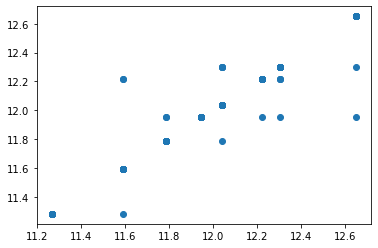

In [36]:
plt.scatter(x=compare_pred['sklearn'], y=compare_pred['new_tree'])
plt.show()

In [80]:
diff = y_pred - y_pred_sk

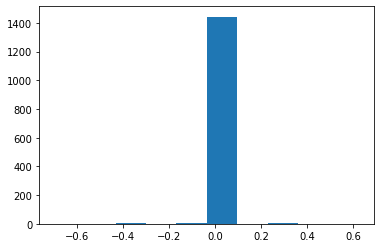

In [81]:
plt.hist(diff)
plt.show()

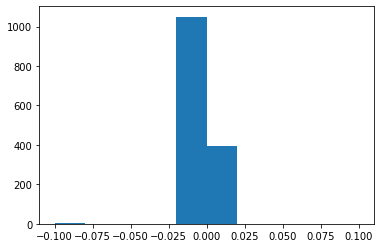

In [82]:
plt.hist(diff, range=(-0.1,0.1))
plt.show()

In [41]:
abs(diff).mean()

0.007008066532321118

In [45]:
df[target].std()

0.3994518682611646

In conclusion, the results are similar, but not identical to, those obtained from using *sklearn*'s **DecisionTreeRegressor**